Current Dir: /mnt/c/Users/moritasemi/WorkSpace/CreativeCoding/SimilarImageSearch
Inpute Image: ../scratch/splites/project1/272590/3.png
Hash Value of Input Image >>> [d0503b4f6c7c4f83]

Project Path: ../scratch/splites/project1/
Project ID: 272590

['../scratch/splites/project1/1000526/1.png',
 '../scratch/splites/project1/1000526/2.png',
 '../scratch/splites/project1/1000960/0.png']
[('../scratch/splites/project1/1065432/12.png', 12),
 ('../scratch/splites/project1/1065432/13.png', 12),
 ('../scratch/splites/project1/1074988/1.png', 12)]


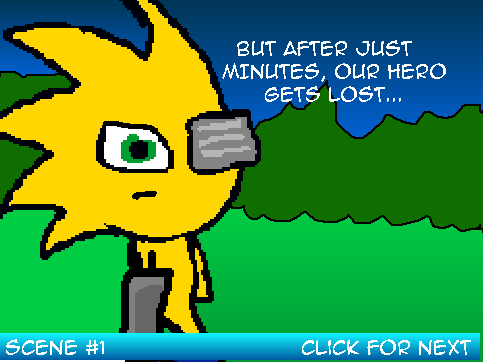

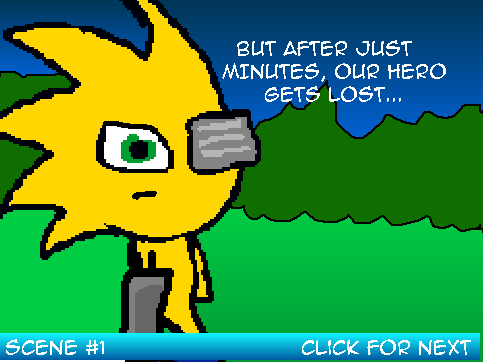

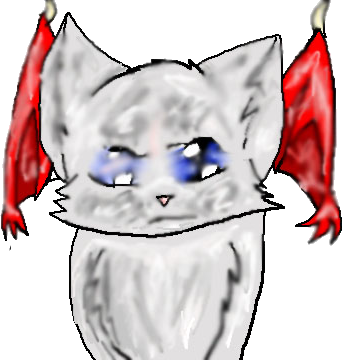

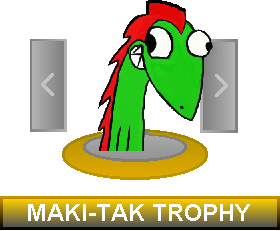

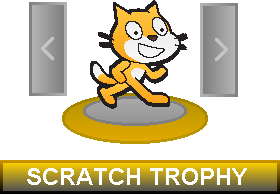

e_time:438.20235991477966[s]


In [244]:
# 2019.01.15
# Python v3.7.2 (Jupyter Notebook v)

from PIL import Image, ImageFile
import numpy as np
import imagehash
import os
from glob import glob
import re
import pprint
from collections import OrderedDict
from IPython.display import display_png
import time

start = time.time()

# ---------------------------------
# Configrations and grobal variables
# ---------------------------------
# 表示する類似画像の個数
showImgNum = 5
# サイズの大きな画像をスキップしない
ImageFile.LOAD_TRUNCATED_IMAGES = True


# ---------------------------------
# Load an input image from  and Calculate the hash value
# ---------------------------------

# inputImg = "../scratch/splites/project1/262284/9.png"
inputImg = "../scratch/splites/project1/272590/3.png"
inputHash = imagehash.phash(Image.open(inputImg))
print("Current Dir: " + os.getcwd())
print("Inpute Image: " + inputImg + "\nHash Value of Input Image >>> [" + str(inputHash) + "]" + "\n")
# TODO jpg対応必要?


# ---------------------------------
# Calculate hash values of other images and difference values
# ---------------------------------
# input画像のパスから、input画像が所属するProjectIDの文字列、
# 他のProjectIDフォルダが所属するプロジェクトフォルダのパスを取得
# "../scratch/splites/project1/262284" \d{1,}は"任意の1桁以上の数値"
path_inputPrjID = re.sub("\d{1,}.png", "", inputImg).strip("/") # imputImg.strip("[0-9].png")はだめだった
# 任意の英数字以外[\W]や英数字[\w]の0回以上の繰り返し*と記号/にマッチする部分を取り除く
prjID = re.sub("[\W\w]*/", "", path_inputPrjID) # "262284"
# "../scratch/splites/project1/" <- 便宜上最後に"/"入れたままなので注意
path_prj = path_inputPrjID.strip(prjID)
print("Project Path: " + path_prj + "\nProject ID: " + prjID + "\n")

# すべての画像のパス取得
pathList = glob(path_prj + "*/*.png") # *はProjectIDをワイルドカードで指定(プロジェクトIDのフォルダごとに回すよりよさそう)
# input画像が所属するProjectIDはハッシュ値算出から取り除く
# 内包表記 [繰り返しindex for 繰り返しindex in 検索元]と[if 特定の文字列 in 検索元]
pathList = [path for path in pathList if prjID not in path]
pprint.pprint(pathList[0:3]) # 0から4-1番目までを取得
# print(len(pathList))

# input画像以外のすべての画像のハッシュ値を算出
hashList = [imagehash.phash(Image.open(img)) for img in pathList]
# print(hashList[0])

# difに2つの画像のハッシュ値の差分を入れる
difList = [abs(inputHash - hashVal) for hashVal in hashList] # intのlistで帰る
# print(difList)
# print(len(difList))


# ---------------------------------
# Create dictionary from other image paths list and difference values list
# ---------------------------------
# Keyがpath、Valueがdifで順序を保った辞書を作る
dic = OrderedDict((pathList[i], difList[i]) for i in range(len(pathList)))
# print(k, v) for k, v in dic.items() # 辞書型の確認はこの方法のみ

# Value(difList(ハッシュ値差分)の値)で降順でソート
# lambdaは無名関数の定義で用いる決まり文句. "x[1]を返す無名の関数をkeyパラメータに入れる"的な意味らしい
# https://qiita.com/n10432/items/e0315979286ea9121d57
sortedDic = sorted(dic.items(), key = lambda x:x[1]) # tupleのlistで帰ってくる
pprint.pprint(sortedDic[0:3])


# ---------------------------------
# Show similar images
# ---------------------------------
[display_png(Image.open(sortedDic[i][0])) for i in range(showImgNum)]


e_time = time.time() - start
print ("e_time:{0}".format(e_time) + "[s]")
